# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.


## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
num_classes = 10  # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784  # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001  # швидкість навчання нейронної мережі
training_steps = 3000  # максимальне число епох
batch_size = 256  # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100  # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128  # кількість нейронів 1-го шару
n_hidden_2 = 256  # кількість нейронів 2-го шару

In [4]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape(
    [-1, num_features]
)

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255.0, x_test / 255.0

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [5]:
# Створимо нейронну мережу


class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)


class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар, який складається з 128 нейронів
        self.layer1 = DenseLayer(num_features, n_hidden_1)
        # Другий шар, який складається з 256 нейронів
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
        # Вихідний шар
        self.out = DenseLayer(n_hidden_2, num_classes)

    def __call__(self, x):
        # Передача даних через перші два шари та вихідний шар з функцією активації softmax
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.out(x, activation=1)

        return x

In [6]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))


# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Перетворюємо передбачення y_pred в індекси класів
    y_pred = tf.argmax(y_pred, 1)
    # Порівнюємо передбачені і дійсні індекси класів
    correct_prediction = tf.equal(y_pred, tf.cast(y_true, tf.int64))
    # Обчислюємо точність
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [7]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")


# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
    # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
    optimizer = tf.optimizers.SGD(learning_rate)

    # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

        # Отримаємо список оптимізованих параметрів
        trainable_variables = neural_net.trainable_variables
        # Обчислимо за ними значення градієнта
        gradients = g.gradient(loss, trainable_variables)

        # Модифікуємо параметри
        optimizer.apply_gradients(zip(gradients, trainable_variables))

In [8]:
# Тренування мережі


loss_history = (
    []
)  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = (
    []
)  # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі


# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:

        pred = neural_net(batch_x)

        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)

        loss_history.append(loss)
        accuracy_history.append(acc)

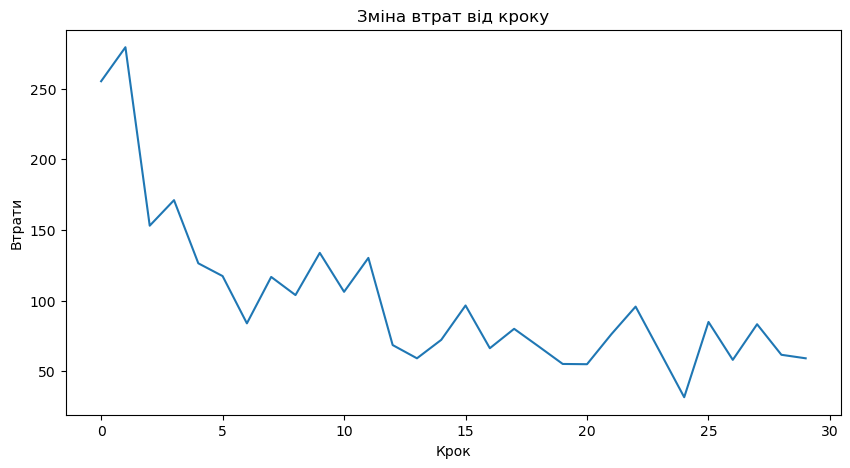

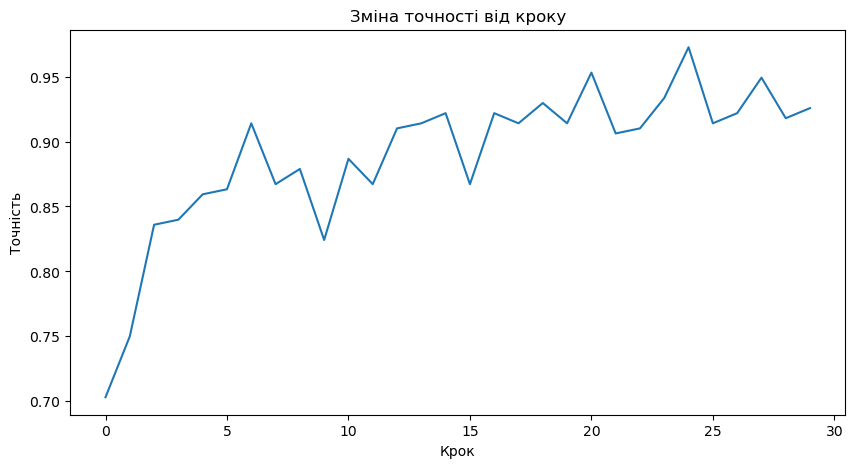

In [9]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title('Зміна втрат від кроку')
plt.xlabel('Крок')
plt.ylabel('Втрати')
plt.show()

# Виведіть графік точності
plt.figure(figsize=(10, 5))
plt.plot(accuracy_history)
plt.title('Зміна точності від кроку')
plt.xlabel('Крок')
plt.ylabel('Точність')
plt.show()


Як бачимо, точність дійсно зростає з кількістю кроків, а втрати зменшуються. 

In [10]:
# Обчисліть точність навченої нейромережі
pred = neural_net(x_test)
acc = accuracy(pred, y_test)
print("Точність навченої нейромережі: {:.2f}%".format(acc*100))

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Тестування моделі на тестових даних
for step, (batch_x, batch_y) in enumerate(test_data.take(training_steps), 1):
    pred = neural_net(batch_x)
    loss = cross_entropy(pred, batch_y)
    acc = accuracy(pred, batch_y)
    print("Крок: {}, Втрати: {:.2f}, Точність: {:.2f}%".format(step, loss, acc*100))

Точність навченої нейромережі: 90.68%
Крок: 1, Втрати: 76.06, Точність: 90.62%
Крок: 2, Втрати: 120.47, Точність: 85.16%
Крок: 3, Втрати: 134.40, Точність: 86.33%
Крок: 4, Втрати: 70.02, Точність: 91.80%
Крок: 5, Втрати: 108.70, Точність: 87.11%
Крок: 6, Втрати: 109.83, Точність: 88.28%
Крок: 7, Втрати: 151.93, Точність: 85.16%
Крок: 8, Втрати: 133.96, Точність: 87.50%
Крок: 9, Втрати: 133.16, Точність: 84.38%
Крок: 10, Втрати: 92.74, Точність: 86.33%
Крок: 11, Втрати: 94.16, Точність: 89.06%
Крок: 12, Втрати: 71.91, Точність: 89.45%
Крок: 13, Втрати: 104.23, Точність: 87.89%
Крок: 14, Втрати: 95.90, Точність: 90.23%
Крок: 15, Втрати: 119.72, Точність: 88.28%
Крок: 16, Втрати: 162.59, Точність: 83.98%
Крок: 17, Втрати: 135.20, Точність: 86.72%
Крок: 18, Втрати: 124.56, Точність: 88.28%
Крок: 19, Втрати: 78.47, Точність: 91.02%
Крок: 20, Втрати: 79.32, Точність: 90.23%
Крок: 21, Втрати: 43.77, Точність: 94.92%
Крок: 22, Втрати: 37.65, Точність: 96.48%
Крок: 23, Втрати: 100.42, Точність:

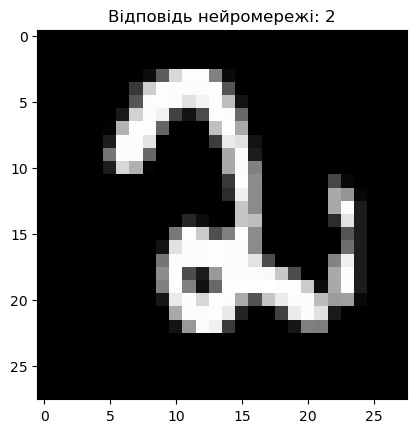

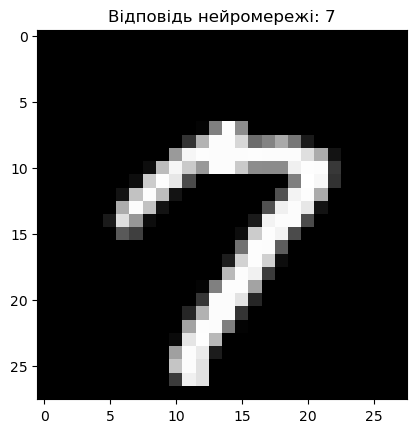

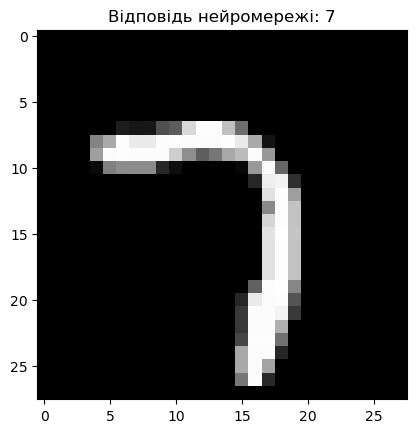

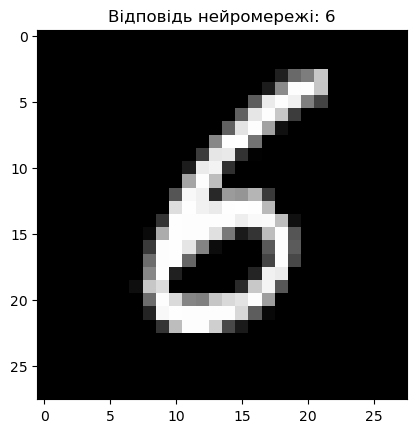

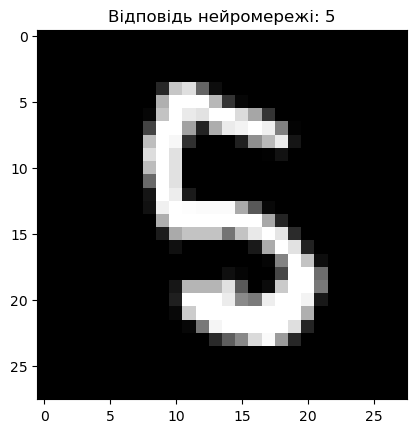

Точність на випадкових зображеннях: 100.00%
Нейромережа помиляється в 0.00% випадків


In [20]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Вибираємо 5 випадкових зображень з тестової вибірки
random_indices = np.random.choice(len(x_test), size=5, replace=False)
random_test_images = x_test[random_indices]
random_test_labels = y_test[random_indices]

# Передаємо зображення в нейронну мережу
predictions = neural_net(random_test_images)

# Перетворюємо передбачення на індекси класів
predicted_classes = tf.argmax(predictions, axis=1)

# Виводимо зображення та відповідь нейромережі
for i, prediction in enumerate(predicted_classes):
    plt.figure(i)
    # Змінюємо форму зображення для коректного відображення
    image_reshaped = (
        random_test_images[i].reshape(28, 28)
    )  # Припускаючи, що зображення мають розмір 28x28
    plt.imshow(image_reshaped, cmap="gray")
    # plt.imshow(random_test_images[i], cmap='gray')
    plt.title("Відповідь нейромережі: {}".format(prediction.numpy()))
    plt.show()

# Порівнюємо відповіді нейромережі з реальними мітками
correct_predictions = np.sum(predicted_classes.numpy() == random_test_labels)
total_predictions = len(predicted_classes.numpy())
accuracy = correct_predictions / total_predictions

print("Точність на випадкових зображеннях: {:.2f}%".format(accuracy*100))
print("Нейромережа помиляється в {:.2f}% випадків".format((1-accuracy)*100))

Вийшов якийсь оверфіттінг майже, але нейромережа показує точність 100%, що насторожує і вражає. 

Я думаю, що це просто показує надвисоку ефективність нейронних мереж у розпізнаванні, і уже два прихованих шари достатньо для такого результату. 